# Create & Run a Local RAG Pipeline from Scratch

## What is RAG?

RAG stands for Retrieval Augmented Generation.

The goal of RAG is to take information and pass it to an LLM, so it can generate outputs based on that information.

* Retrieval - Find relevant information given a query, e.g. "What are the macronutrients & what do they do?" -> retrieves passages of text related to the macronutrients from a nutrition textbook.

* Augmented - We want to take the relevant information & augment our input (prompt) to an LLM with that relevant information.

* Generation - Take the first 2 steps & pass them to an LLM for generative outputs.

Where RAG came from - Facebook / Meta AI Paper: *Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*
> This work offers several positive societal benefits over previous work: the fact that it is more strongly grounded in real factual knowledge (in this case Wikipedia) makes it “hallucinate” less with generations that are more factual, and offers more control and interpretability. RAG could be employed in a wide variety of scenarios with direct benefit to society, for example by endowing it with a medical index and asking it open-domain questions on that topic, or by helping people be more effective at their jobs.

## Why RAG?

The main goal of RAG is to improve the generation outputs of LLMs.

1. Prevent hallucinations - LLMs are incredibly good at generating good *looking* text, however, this text doesn't mean that it is factual. RAG can help LLMs generate information based on relevant passages that are factual.

2. Work with custom data - Many base LLMs are trained with internet-scale data. This means they have a fairly good understanding of language in general. However, it also does a lot of their responses can be generic in nature. RAG helps to create specific responses based on specific documents (e.g. your own companies customer support documents).

## What can RAG be used for?

* Customer Support Q&A Chat - Treat your existing customer support documents as a resource and when a customer asks a question, you could have a retrieval system, retrieve relevant documentation snippets & then have a LLM craft those snippets into an answer. Think of this as a "chatbot for your documentation".

* Email Chain Analysis - Let's say you are a large insurance company & you have chains and chains of emails of customer claims. You could use a RAG pipeline to find relevant information from those emails & then use an LLM to process that information into structured data.

* Company Interval Documentation Chat

* Textbook Q&A - Let's say you are a nutrition student and you've got a 1200 pages textbook read, you could build a RAG pipeline to go through the textbook and find relevant passages to the questions you have.

Common theme here: Take your relevant documents to a query & process them with an LLM.

From this angle, consider LLM as a calculator for words.

## Why Local?

Fun.

Privacy, Speed, Cost.

* Privacy - If you have private documentation, maybe you don't want to send that to an API. You want to setup an LLM and run it on your own hardware.
* Speed - Whenever you use an API, you have to send some kind of data across the internet. This takes time. Running locally means we don't have to wait for transfers of data.
* Cost - If you own your hardware, the cost is paid. It may have a large cost to begin with. But overtime, you don't have to keep paying API fees.
* No Vendor Lock-in - If you run your own software/ hardware. If Large company shuts down tomorrow, you can still run your business.

## What Will Be Built?

Build NutriChat to "chat with a nutrition document".

Specifically:

1. Open a PDF document (you could use almost any PDF here or even a collection of PDFs).
2. Format the text of the PDF textbook ready for an embedding model.
3. Embbed all of the chunks of text in the textbook, and turn them into numerical representations (embeddings) which can store for later.
4. Build a retrieval system that uses vector search to find relevant chunk of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on the passages of the textbook with an LLM.

All Locally!

1. Steps 1 - 3: Document Preprocessing & Embedding Creation.
2. Steps 4 - 6: Search & Answer.

## 1. Document / Text Preprocessing & Embedding Creation

Ingredients:
* PDF document of choice (note: this could be almost any kind of document, just that PDFs are focused for now).
* Embedding model of choice

Steps:
1. Import PDF Document.
2. Preprocess Text for Embedding (e.g. Split into Chunks of Sentences).
3. Embbed Text Chunks with Embedding Model.
4. Save Embeddings to File for Later (Embeddings will store on files for many years or until you lose your hard drive).

## Import PDF Document

In [1]:
import os
import requests

In [2]:
# path to document
pdf_path = 'human-nutrition-text.pdf'

# download PDF
if not os.path.exists(pdf_path):
    print(f'[INFO] File does not exist, downloading...')

    # url of the pdf
    url = 'https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf'

    # the local file name to save the downloaded file
    fname = pdf_path

    # GET request
    res = requests.get(url)

    # check if the request is successful
    if res.status_code == 200:
        # open the file & save it
        with open(fname, 'wb') as f:
            f.write(res.content)
        print(f'[INFO] The file has been downloaded & saved as {fname}.')
    else:
        print(f'[INFO] Failed to download the file. Status Code: {res.status_code}')
else:
    print(f'[INFO] File {pdf_path} exists.')

[INFO] File does not exist, downloading...
[INFO] The file has been downloaded & saved as human-nutrition-text.pdf.


PDF is now available, let's open it.

In [3]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 76.7 MB/s eta 0:00:00


In [4]:
import fitz # from PyMuPDF
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    '''Performs minor formatting on text.'''
    cleaned_text = text.replace('\n', ' ').strip()

    return cleaned_text

def open_and_read_pdf(path: str) -> list[dict]:
    doc = fitz.open(path)
    pages_and_texts = []

    for page_no, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({'page_no': page_no - 41,
                                'page_char_cnt': len(text),
                                'page_word_cnt': len(text.split(' ')),
                                'page_sentence_cnt_raw': len(text.split('. ')),
                                'page_token_cnt': len(text) / 4, # 1 token ~ 4 chars
                                'text': text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_no': -41,
  'page_char_cnt': 29,
  'page_word_cnt': 4,
  'page_sentence_cnt_raw': 1,
  'page_token_cnt': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_no': -40,
  'page_char_cnt': 0,
  'page_word_cnt': 1,
  'page_sentence_cnt_raw': 1,
  'page_token_cnt': 0.0,
  'text': ''}]

In [5]:
import random

random.sample(pages_and_texts, k=3)

[{'page_no': 382,
  'page_char_cnt': 765,
  'page_word_cnt': 123,
  'page_sentence_cnt_raw': 4,
  'page_token_cnt': 191.25,
  'text': 'Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.  \xa0 An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=254  \xa0 382  |  Protein Digestion and Absorption'},
 {'page_no': 857,
  'page_char_cnt': 1470,
  'page_word_cnt': 253,
  'page_sentence_cnt

In [6]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_no,page_char_cnt,page_word_cnt,page_sentence_cnt_raw,page_token_cnt,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [7]:
df.describe().round(2)

,page_no,page_char_cnt,page_word_cnt,page_sentence_cnt_raw,page_token_cnt
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


Why would we care about token count?

Token count is important to think about because:

1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example, an embedding model may have been trained to embbed sequences of 384 tokens into numerical space (sentence-transformers `all-mpnet-base-v2`, see: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html)

As for LLMs, they can't accept infinite tokens in their context window.

## Further Text Preprocessing

Splitting pages into sentences.

2 Ways to do this:

1. Done this by splitting on `'.'`.
2. Do this by NLP library, such as spaCy and nltk.

In [8]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline (turning texts into sentences)
nlp.add_pipe('sentencizer')

# Create document instance as an example
doc = nlp('This is a sentence. This is another sentence. I like elephants.')
assert len(list(doc.sents)) == 3

# Print sentences split
list(doc.sents)

[This is a sentence., This is another sentence., I like elephants.]

# New Section

In [9]:
pages_and_texts[0]

{'page_no': -41,
 'page_char_cnt': 29,
 'page_word_cnt': 4,
 'page_sentence_cnt_raw': 1,
 'page_token_cnt': 7.25,
 'text': 'Human Nutrition: 2020 Edition'}

In [10]:
for item in tqdm(pages_and_texts):
    item['sentences'] = list(nlp(item['text']).sents)

    # Make sure all sentences are string (default type is spaCy data type)
    item['sentences'] = [str(sentence) for sentence in item['sentences']]

    # Count the sentences
    item['page_sentence_cnt_spacy'] = len(item['sentences'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [11]:
random.sample(pages_and_texts, k=1)

[{'page_no': 529,
  'page_char_cnt': 1273,
  'page_word_cnt': 262,
  'page_sentence_cnt_raw': 21,
  'page_token_cnt': 318.25,
  'text': 'Food  Serving Vitamin A (IU) Percent Daily Value  Beef liver  3 oz.  27,185  545  Chicken liver  3 oz.  12,325  245  Milk, skim  1 c.  500  10  Milk, whole  1 c.  249  5  Cheddar cheese 1 oz.  284  6  Source: Dietary Supplement Fact Sheet: Vitamin A. National  Institutes  of  Health,  Office  of  Dietary  Supplements.  http://ods.od.nih.gov/factsheets/VitaminA-QuickFacts/. Updated  September 5, 2012. Accessed October 7, 2017.  In the United States, the most consumed carotenoids are alpha- carotene, beta-carotene, beta-cryptoxanthin, lycopene, lutein, and  zeaxanthin. See Table 9.3 “Alpha- and Beta-Carotene Content of  Various Foods” for the carotenoid content of various foods.  Table 9.3 Alpha- and Beta-Carotene Content of Various Foods  Food  Serving  Beta-carotene  (mg)  Alpha-carotene  (mg)  Pumpkin, canned  1c.  17.00  11.70  Carrot juice  1c.  22

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_no,page_char_cnt,page_word_cnt,page_sentence_cnt_raw,page_token_cnt,page_sentence_cnt_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chunking our sentences together

The concept of splitting larger pieces of texts into smaller ones, often refer to as `text splitting` or `chunking`.

There is no 100% of correct way to do this - experiment!

To keep it simple, it will split into groups of 10 sentences.

There are frameworks such as `langchain` which can help with this, but we will use `python` for now.
- https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/

Why do we do this:
1. So the texts are easier to filter (smaller group of texts can be easier to inspect than large passages of texts).
2. So the text chunks can fit into the embedding model of context. (eg. 384 tokens has a limit).
3. So the contexts passed into LLM can be more specific and focused.

In [13]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split lists of texts recurively into chunk size
# eg. [20] -> [10, 10] or [25] -> [10, 10, 5]
def split_list(input_list: list[str],
               split_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i : i + split_size] for i in range(0, len(input_list), split_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [14]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item['sentence_chunks'] = split_list(input_list=item['sentences'],
                                         split_size=num_sentence_chunk_size)
    item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [15]:
random.sample(pages_and_texts, k=1)

[{'page_no': 938,
  'page_char_cnt': 1151,
  'page_word_cnt': 199,
  'page_sentence_cnt_raw': 9,
  'page_token_cnt': 287.75,
  'text': 'Image by  Cosmed /  CC BY-SA  3.0  Muscle Strength  Muscle strength is developed and maintained by weight or  resistance training that often is called anaerobic exercise. Anaerobic  exercise consists of short duration, high intensity movements that  rely on immediately available energy sources and require little or  no oxygen during the activity. This type of high intensity training  is used to build muscle strength by short, high intensity activities.  Building muscle mass is not just crucial for athletes and  bodybuilders—building muscle strength and endurance is important  for children, seniors, and everyone in between. The support that  your muscles provide allows you to work, play, and live more  efficiently. Strength training involves the use of resistance  machines, resistance bands, free weights, or other tools. However,  you do not need to pay

In [16]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_no,page_char_cnt,page_word_cnt,page_sentence_cnt_raw,page_token_cnt,page_sentence_cnt_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item

We'd like to embbed each chunk of sentences into its own numerical representation.

That'll give us a good level of granularity.

Meaning, we can dive specifically into text sample that was used in our model.

In [17]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_no'] = item['page_no']

        # Join the sentences together into paragraph-like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = ''.join(sentence_chunk).replace('  ', ' ').strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # '.A' -> '. A'

        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        # get some stats on the chunks
        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk_word_count'] = len([word for word in joined_sentence_chunk.split(' ')])
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk) / 4 # 1 token = ~4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [18]:
random.sample(pages_and_chunks, k=1)

[{'page_no': 81,
  'sentence_chunk': 'http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=84 \xa0 The Digestive System | 81',
  'chunk_char_count': 83,
  'chunk_word_count': 8,
  'chunk_token_count': 20.75}]

In [19]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_no,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


### Filter chunks of texts for short chunks

These chunks may not contain much useful information.

In [20]:
# Show random chunks with under 30 tokens in length
min_token_len = 30

for row in df[df['chunk_token_count'] <= min_token_len].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 9.75 | Text: 920 | Older Adulthood: The Golden Years
Chunk token count: 21.5 | Text: http://www.health.gov.fj/?page_id=1406. Accessed November 12, 2017. 652 | Introduction
Chunk token count: 12.75 | Text: PART VIII CHAPTER 8. ENERGY Chapter 8. Energy | 451
Chunk token count: 16.25 | Text: Health Consequences and Benefits of High-Carbohydrate Diets | 267
Chunk token count: 27.75 | Text: view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=144 Regulation of Water Balance | 171


In [21]:
# Filter DataFrame for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df['chunk_token_count'] > min_token_len].to_dict(orient='records')
pages_and_chunks_over_min_token_len[:2]

[{'page_no': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_no': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [22]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_no': 1001,
  'sentence_chunk': 'Virus Viruses are another type of pathogen that can lead to food infections, however they are less predominant than bacteria. Viruses differ from bacteria in that they cannot grow and reproduce in foods. Instead, viruses that cause human diseases can only reproduce inside human cells (see Figure 15.1 “Viruses in the Human Body”). Hepatitis A is one of the more well-known food- contaminating viruses. Sources include raw shellfish from polluted water, and food handled by an infected person. This virus can go undetected for weeks and, on average, symptoms do not appear until about one month after exposure. At first, symptoms include malaise, loss of appetite, nausea, vomiting, and fever. Three to ten days later, additional symptoms can manifest, including jaundice and darkened urine. Severe cases of a hepatitis A can result in liver damage and death. The most common form of contamination from handled foods is the norovirus, which is also known as th

### Embedding Text Chunks

Embeddings are a broad but powerful concept.

While humans understand text, machines understand numbers.

What we'd like to do:
- Turn our text chunks into numbers, specifically embeddings.

A useful numerical representation.

The best part about embeddings is that are a *leanred* representation.

eg. (in reality is very high in dimensions)
```
'a': 0
'the': 1
```

In [23]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 8.5 MB/s eta 0:00:00


In [24]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2',
                                      device='cpu')

# create a list of sentences
sentences = ['The Sentence Transformer libary provides an easy way to create embeddings.',
             'Sentences can be embedded one by one or in a list.',
             'I like horses!']

# sentences are encoded / embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# see the embeddings
for sentence, embedding in embeddings_dict.items():
  print(f'Sentence: {sentence}')
  print(f'Embedding: {embedding}')
  print()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentence Transformer libary provides an easy way to create embeddings.
Embedding: [-2.99809258e-02  2.60944441e-02 -2.29293182e-02  6.35950193e-02
 -1.93733852e-02 -4.49128868e-03  9.92164481e-03 -4.67882603e-02
  1.22559704e-02 -2.75071971e-02  2.65685096e-02  5.37344031e-02
 -3.85486670e-02  1.32278781e-02  4.85130474e-02 -4.82199490e-02
  4.89330627e-02  1.24479039e-02 -3.11447121e-02 -2.84715497e-04
  3.22387442e-02  2.24109069e-02  2.44734939e-02  4.07999158e-02
 -1.42253069e-02 -1.04100714e-02  9.76622105e-04 -4.08064350e-02
  4.98060398e-02 -6.61029527e-03 -3.11633702e-02 -9.80590936e-03
  5.56001663e-02  1.03649904e-03  1.02035779e-06  5.70026366e-03
 -3.94802168e-02 -6.44746749e-03  1.08795157e-02 -4.85750008e-03
  4.14261967e-02 -6.11539334e-02  1.98641196e-02  5.36944531e-02
 -4.52736169e-02 -1.35530112e-02  4.97608110e-02  1.83713511e-02
  9.01330560e-02  5.36868684e-02 -2.36761589e-02 -4.49782237e-02
  7.29150139e-03 -2.20345184e-02 -1.63787883e-02  2.3345751

In [25]:
embeddings[0].shape

(768,)

In [26]:
embedding = embedding_model.encode('My favourite animal is the cow!')
embedding

array([-1.45473219e-02,  7.66726732e-02, -2.85872221e-02, -3.31283063e-02,
        3.65210250e-02,  4.78570834e-02, -7.08107576e-02,  1.62834357e-02,
        1.93444230e-02, -2.80482098e-02, -2.91746911e-02,  5.11310287e-02,
       -3.28720361e-02, -8.98752734e-03, -1.03672249e-02, -3.15488093e-02,
        4.22783941e-02, -9.13282856e-03, -1.94017068e-02,  4.35689092e-02,
       -2.31997557e-02,  4.29883264e-02, -1.72393396e-02, -2.01372392e-02,
       -3.13573666e-02,  8.08165409e-03, -2.06724815e-02, -2.27869265e-02,
        2.44812462e-02,  1.71968006e-02, -6.26673251e-02, -7.54796863e-02,
        3.57421823e-02, -5.46575431e-03,  1.24730309e-06, -7.63201015e-03,
       -3.53222117e-02,  1.91326998e-02,  3.99045907e-02,  2.11727014e-03,
        1.64565220e-02,  9.84047633e-03, -1.80700384e-02,  9.33832116e-03,
        3.23483311e-02,  5.84786497e-02,  4.23187613e-02,  1.62091330e-02,
       -9.14911553e-02,  1.82305649e-02, -5.25729870e-03, -7.81014515e-03,
       -3.47644053e-02, -

In [27]:
# %%time

# embedding_model.to('cpu')

# # embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item['embedding'] = embedding_model.encode(item['sentence_chunk'])

In [28]:
%%time

embedding_model.to('cuda')

# embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item['embedding'] = embedding_model.encode(item['sentence_chunk'])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 35.8 s, sys: 608 ms, total: 36.4 s
Wall time: 44.2 s


In [29]:
%%time

text_chunks = [item['sentence_chunk'] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: user 417 µs, sys: 26 µs, total: 443 µs
Wall time: 447 µs


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [30]:
len(text_chunks)

1680

In [31]:
%%time

# embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True)
text_chunk_embeddings

CPU times: user 24.2 s, sys: 82.6 ms, total: 24.3 s
Wall time: 23.9 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

### Save embeddings to file

In [32]:
pages_and_chunks_over_min_token_len[419]

{'page_no': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to t

In [33]:
# save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = 'text_chunks_and_embeddings_df.csv'
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [34]:
# import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_no,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


If your embedding database is really large (eg. over 100k-1M samples), you might want to look into using a vector database for storage.

## RAG - Search & Answer

RAG goal: Retrieved relevant passages based on a query and use those passages to augment an input to an LLM so it can generate output based on those relevant passages.

### Similarity Search

Embeddings can be used for almost any type of data.

For example, you can turn images into embeddings, sound into embeddings, text into embeddings, etc...

Comparing embeddings is known as similarity search, vector search, semantic search.

In our case, we want to query our nutrition textbook passages based on semantics or *vibe*.

So, if search for 'macronutrient functions', the relevant passages to that text should return, but may not contain exactly the words 'macronutrient functions'.

Whereas with keyword search, if 'apple' is searched, the passages return with specifically 'apple'.

In [51]:
import random
import numpy as np
import pandas as pd
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# import texts and embedding df
text_chunks_and_embeddings_df = pd.read_csv('text_chunks_and_embeddings_df.csv')

# convert embedding column back to np.array (it got converted to string when it was saved to csv)
text_chunks_and_embeddings_df['embedding'] = text_chunks_and_embeddings_df['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

# convert embedding into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df['embedding'].tolist(), axis=0), dtype=torch.float32).to(device)

# convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient='records')

text_chunks_and_embeddings_df.head()

,page_no,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."


In [52]:
embeddings.shape

torch.Size([1680, 768])

In [53]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2', device=device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Embedding model ready.

Let's create a small semantic search pipeline.

In essensce, we want to search for a query (eg. 'macronutrient functions') and get back relevant passages from the textbook.

We can do by:
1. Define a query string.
2. Turn the query string into an embedding.
3. Perform a dot product or cosine similarity function between the text embeddings and the query embedding.
4. Sort the result from 3 in descending order.

In [54]:
embeddings.shape

torch.Size([1680, 768])

Note: to use dot product for comparison, ensure vector sizes are of same shape (eg. 768) and tensors/vectors are in same datatype (eg. both in float32)

In [55]:
# 1. Define the query
query = 'macronutrient functions'
print(f'Query: {query}')

# 2. Embed the query
# use SAME model that uses to embed the documents
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()
print(f'[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time}:.5f seconds.')

# 4. Get the top K results (keep this to top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrient functions
[INFO] Time taken to get scores on 1680 embeddings: 0.022005322999802956:.5f seconds.


torch.return_types.topk(
values=tensor([0.6843, 0.6717, 0.6517, 0.6493, 0.6478], device='cuda:0'),
indices=tensor([42, 47, 46, 51, 41], device='cuda:0'))

In [56]:
query_embedding.dtype, embeddings[0].dtype

(torch.float32, torch.float32)

In [59]:
# highest score is index 42
pages_and_chunks[42]

{'page_no': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of carbon,

In [61]:
100 * 1680 # words

300000000

In [60]:
larger_embeddings = torch.randn(100 * embeddings.shape[0], 768).to(device)
print(f'Embeddings shape: {larger_embeddings.shape}')

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f'[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time}:.5f seconds.')

Embeddings shape: torch.Size([168000, 768])
[INFO] Time taken to get scores on 1680 embeddings: 0.0007604639999954088:.5f seconds.


We can see that searching over embeddings is very fast even with exhaustive search.

But if you had 10M+ embeddings, likely want to create an index.

An index is like letters in the dictionary.

For example, if want to search 'duck' in the dictionary, you'd start at d, then find words close to 'du..' etc.

An index helps to narrow it down.

A popular indexing library for vector search is Faiss (Facebook AI Similarity Search). One technique the library provides - approximate nearest neighbour search (ann, similar to knn).

Let's make the vector search result pretty.

In [63]:
import textwrap

def print_wrapped(text, wrap_length=80):
  wrapped_text = textwrap.fill(text, wrap_length)
  print(wrapped_text)

In [67]:
print(f'Query: "{query}"\n')
print('Results:')
# Loop through zipped together scores and indices from torhc.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
  print(f'Score: {score:.4f}')
  print('Text:')
  print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
  print(f"Page number: {pages_and_chunks[idx]['page_no']}")
  print()

Query: "macronutrient functions"

Results:
Score: 0.6843
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are m

Note: Can potentially improve the order of these results with a re-ranking model. A model that has been trained specifically to take search results (eg. the top 25 semantic results) and rank them in order from most likely top-1 to least likely.

An open-source re-ranking model: https://huggingface.co/mixedbread-ai

To check the results, what if we wanted to automatically surface the page of texts related to the query?

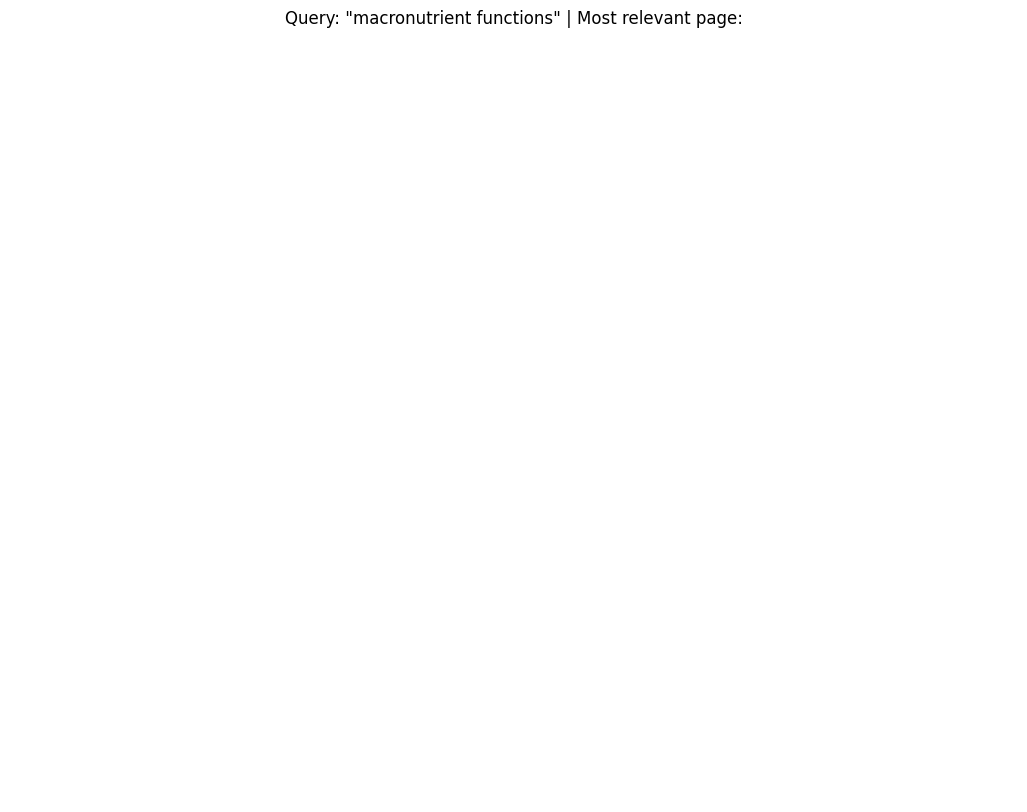

In [69]:
import fitz # pymupdf library

# open PDF and load target
pdf_path = 'human-nutrition-text.pdf'
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # note: page numbers of the pdf start 41+

# get the image of the page
img = page.get_pixmap(dpi=300)

# save image
# img.save('output_filename.png')
doc.close()

# convert the pixmap to numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

# display the image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.title(f'Query: "{query}" | Most relevant page:')
plt.axis(False)
plt.show()

### Similarity Measures: Dot Product & Cosine Similarity